# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

План работы:

1. Работа с историческими данными (загрузка и знакомство с данными, анализ числа регистраций и числа просмотренных страниц, изучение доли пользователей, просмотревших более 4 старниц)

2. Подготовка к тесту(формулировка нулевой и альтернативной гипотез, расчет размера выборки и длительности А/В теста)

3. Мониторинг А/В теста (проверка распределения и пересечения пользователей, проверка равномерности распределения пользователей по устройствам и регионам)

4. Проверка результатов А/В (Получение результатов теста и подсчет основной метрики, проверка корректности результатов, сравнение доли успешных тестов, насколько статистически значимо изменение ключевой метрики).

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [2]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from math import *
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind


In [3]:
# Эта ячейка исправит проблему SSL если она есть
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [4]:
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [5]:
# Отобразим для каждого уникального пользователя количество уникальных сессий в порядке убывания
display(sessions_history.groupby('user_id')['session_id'].nunique().sort_values(ascending = False)) # Первая строчка - тот самый пользователь с наибольшим количеством сессий

# Отобразим строку со всеми столбцами для одного пользователя с наибольшим количеством сессий
display(sessions_history[sessions_history['session_number'] == sessions_history['session_number'].max()].head(1))


user_id
10E0DEFC1ABDBBE0    10
6A73CB5566BB494D    10
8A60431A825D035B     9
D11541BAC141FB94     9
5BCFE7C4DCC148E9     9
                    ..
1DF13BB1953B3497     1
628502A3CE7E0A3C     1
1DEEF40DEFBD0C65     1
AC08479B7472C628     1
8A0882B6715D9EE5     1
Name: session_id, Length: 134039, dtype: int64

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


Можно заметить, что столбец `session_number` отображает именно порядковый номер сессии, поэтому его максимальное значение будет общим количеством сессий для пользователя. Можно сделать вывод, что у пользователя, строчку с данными которого мы вывели выше, существует еще 9 строчек с таким же `user_id`, но с отличающимся значением в столбце `session_number` и такие строки не будут являться дубликатами. В таком случае будут отличаться еще столбцы `page_counter`, `session_id`, `session_date`, `session_start_is`, возможно еще `device`.

In [6]:
# отобразим для примера все строки датафрейма для пользователя с id = 10E0DEFC1ABDBBE0
sessions_history[(sessions_history['session_number']>=1)&(sessions_history['user_id'] == '10E0DEFC1ABDBBE0')]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

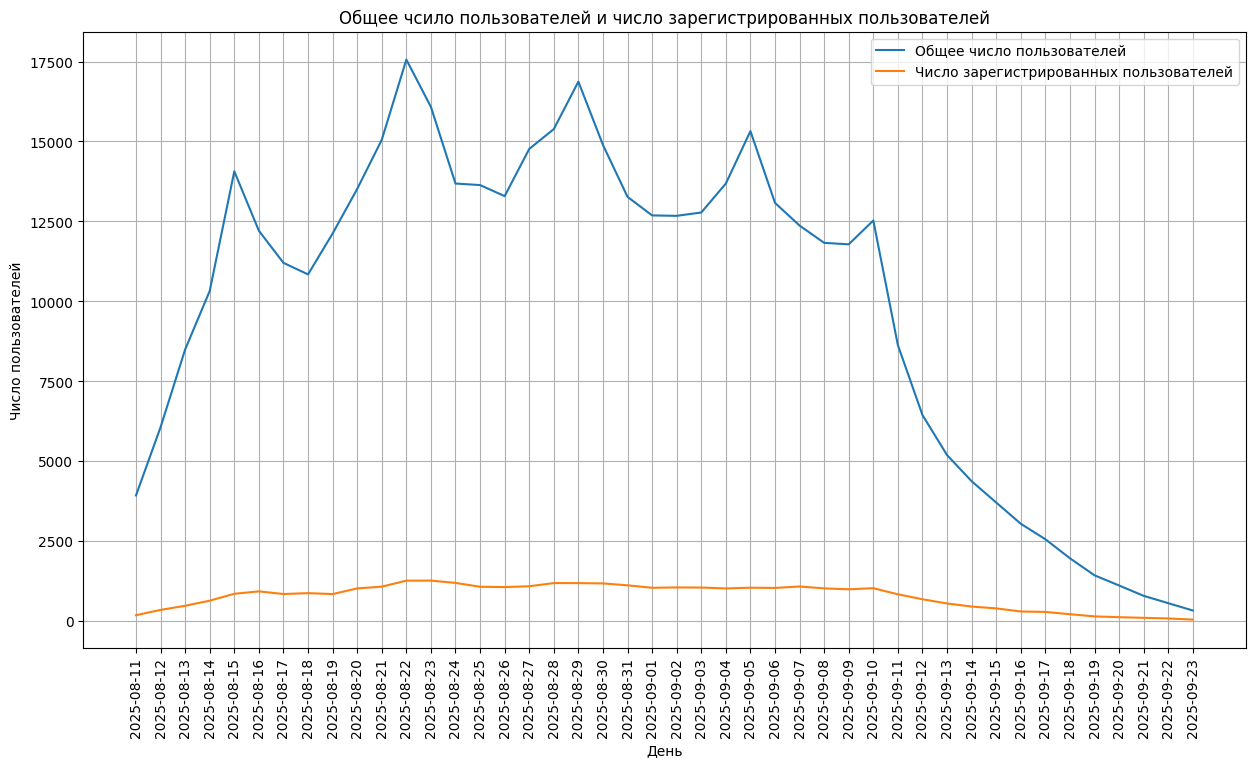

In [7]:
# Считаем уникальное общее число пользователей по дням
sessions_history_131 = sessions_history.groupby('session_date')['user_id'].nunique()

# Фильтруем данные для числа зарегистрированных пользователей
sessions_history_1321 = sessions_history[(sessions_history['registration_flag']== 1)]

# Считаем уникальное число зарегистрированных пользователей по дням
sessions_history_132 = sessions_history_1321.groupby('session_date')['user_id'].nunique()

# Строим график, отображающий общее число пользователей по дням
plt.figure(figsize=(15, 8))
plt.plot(
    sessions_history_131.index,
    sessions_history_131.values,
    label='Общее число пользователей'
)

# Строим график, отображающий кол-во зарегистрировнных пользователей по дням
plt.plot(
    sessions_history_132.index,
    sessions_history_132.values,
    label='Число зарегистрированных пользователей')
plt.xlabel("День")
plt.xticks(rotation=90)
plt.legend()
plt.ylabel('Число пользователей')
plt.title('Общее чсило пользователей и число зарегистрированных пользователей')
plt.grid(True)
plt.show()

In [8]:
# Построим сводные таблицы, чтобы видеть более точные данные по датам
piv1 = pd.pivot_table(sessions_history, values = 'user_id' , index='session_date', aggfunc='nunique')
piv2 = pd.pivot_table(sessions_history_1321, values = 'user_id' , index='session_date', aggfunc='nunique')

display(piv1, piv2)

,user_id
session_date,
2025-08-11,3919
2025-08-12,6056
2025-08-13,8489
2025-08-14,10321
2025-08-15,14065
2025-08-16,12205
2025-08-17,11200
2025-08-18,10839
2025-08-19,12118


,user_id
session_date,
2025-08-11,169
2025-08-12,336
2025-08-13,464
2025-08-14,625
2025-08-15,840
2025-08-16,916
2025-08-17,833
2025-08-18,860
2025-08-19,831


Промежуточный вывод:

- Можно заметить, что в датафрейме с историческими данными к концу периода общее число пользователей уменьшилось. На протяжении всего периода общее число пользователей не было стабильно, график имеет пять "пиковых" значений, можно наблюдать резкие скачки в количестве пользователей и спады.

- Число зарегистрированных пользователей стабильно на протяжении всего периода, не имеет резких скачков и спадов значений. В конце периода наблюдается плавное уменьшение кол-ва зарегистрированных пользователей.

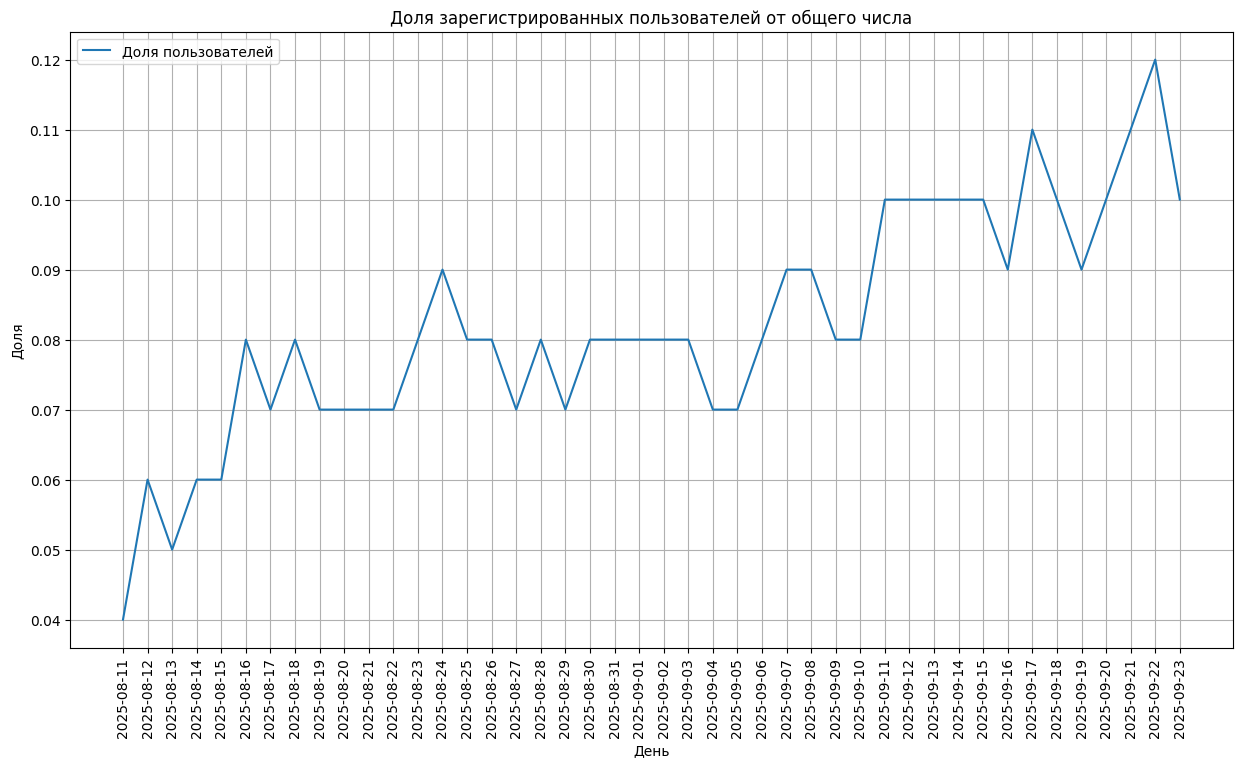

session_date
2025-08-11    0.04
2025-08-12    0.06
2025-08-13    0.05
2025-08-14    0.06
2025-08-15    0.06
2025-08-16    0.08
2025-08-17    0.07
2025-08-18    0.08
2025-08-19    0.07
2025-08-20    0.07
2025-08-21    0.07
2025-08-22    0.07
2025-08-23    0.08
2025-08-24    0.09
2025-08-25    0.08
2025-08-26    0.08
2025-08-27    0.07
2025-08-28    0.08
2025-08-29    0.07
2025-08-30    0.08
2025-08-31    0.08
2025-09-01    0.08
2025-09-02    0.08
2025-09-03    0.08
2025-09-04    0.07
2025-09-05    0.07
2025-09-06    0.08
2025-09-07    0.09
2025-09-08    0.09
2025-09-09    0.08
2025-09-10    0.08
2025-09-11    0.10
2025-09-12    0.10
2025-09-13    0.10
2025-09-14    0.10
2025-09-15    0.10
2025-09-16    0.09
2025-09-17    0.11
2025-09-18    0.10
2025-09-19    0.09
2025-09-20    0.10
2025-09-21    0.11
2025-09-22    0.12
2025-09-23    0.10
Name: user_id, dtype: float64

In [9]:
# Считаем долб зарегистрировнных пользователей
sessions_history_13 = round(sessions_history_132 / sessions_history_131, 2)

# Строим линейнфй график, отображающий долю зарегистрировнных пользователей от их общего кол-ва
plt.figure(figsize=(15, 8))
plt.plot(
    sessions_history_13.index,
    sessions_history_13.values,
    label='Доля пользователей')
plt.xlabel("День")
plt.xticks(rotation=90)
plt.legend()
plt.ylabel('Доля')
plt.title('Доля зарегистрированных пользователей от общего числа')
plt.grid(True)
plt.show()

display(sessions_history_13)

Промежуточный вывод:
 - Можно заметить, что относительные значения кол-ва зарегистрированных пользователей не стабильны, график имеет резкие скачки и спады. несмотря на это, доля пользователей растет и график по своей динамике восходящий.

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

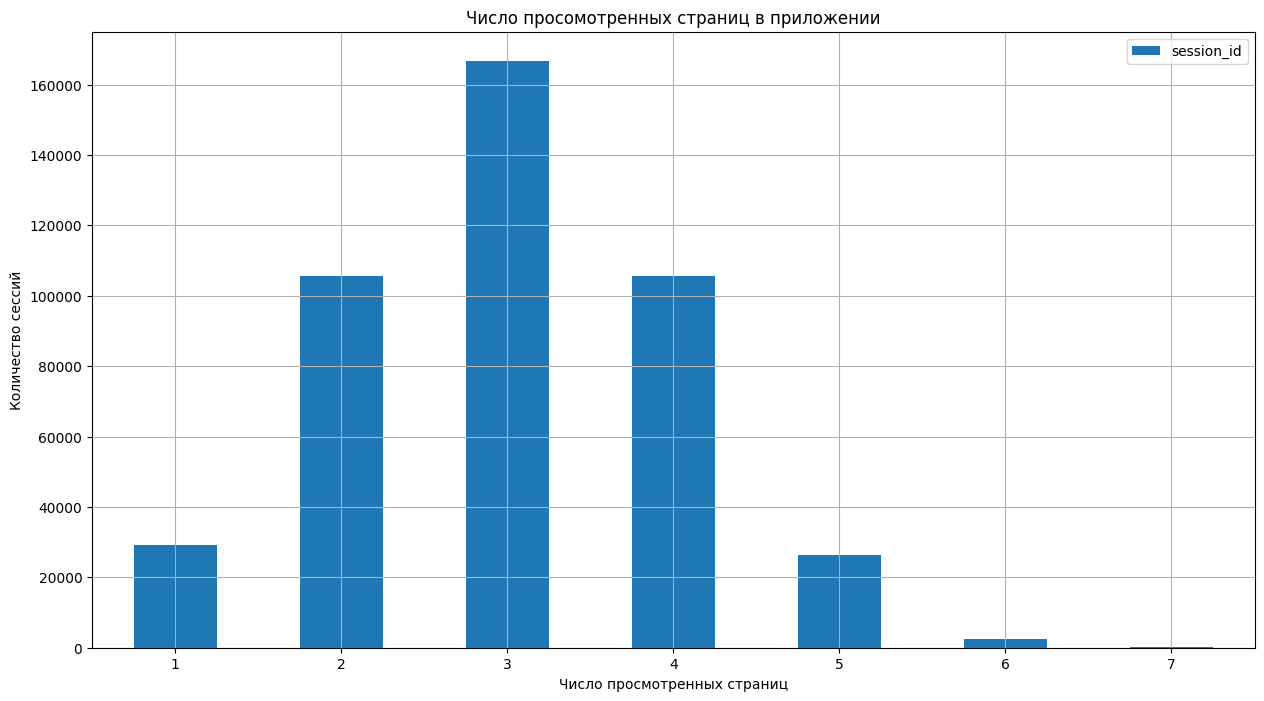

In [10]:
# Сохраняем в переменнуб количество сесси для каждого значения количесвта просмотренных страниц
pages_count = sessions_history.groupby('page_counter')['session_id'].count().reset_index()

# Строим на основании выше сохраненной переменной столбчатую диаграмму
pages_count.plot(kind='bar', x='page_counter', y='session_id', figsize=(15, 8))
plt.xlabel('Число просмотренных страниц')
plt.xticks(rotation=0)
plt.legend()
plt.ylabel('Количество сессий')
plt.title('Число просомотренных страниц в приложении')
plt.grid(True)
plt.show()

In [11]:
# Построим сводные таблицы, чтобы видеть более точные данные
piv3 = pd.pivot_table(sessions_history, values = 'session_id' , index='page_counter', aggfunc='count')

display(piv3)

,session_id
page_counter,
1,29160
2,105536
3,166690
4,105569
5,26288
6,2589
7,92


Промежуточный вывод:
- Наибольшее число сессий - 166 690 (значение числа просмотренных страниц 3)
- Наименьшее число сессий - 92 (знаечние числа просмотренных страниц 7).


#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [12]:
# Создаем столбец good_session, который определяет успешность сессии
good_session = []

for i in sessions_history['page_counter']:
    if i >=4:
        good_session.append(1)
    else:
        good_session.append(0)

sessions_history['good_session'] = good_session

display(sessions_history.head(5))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


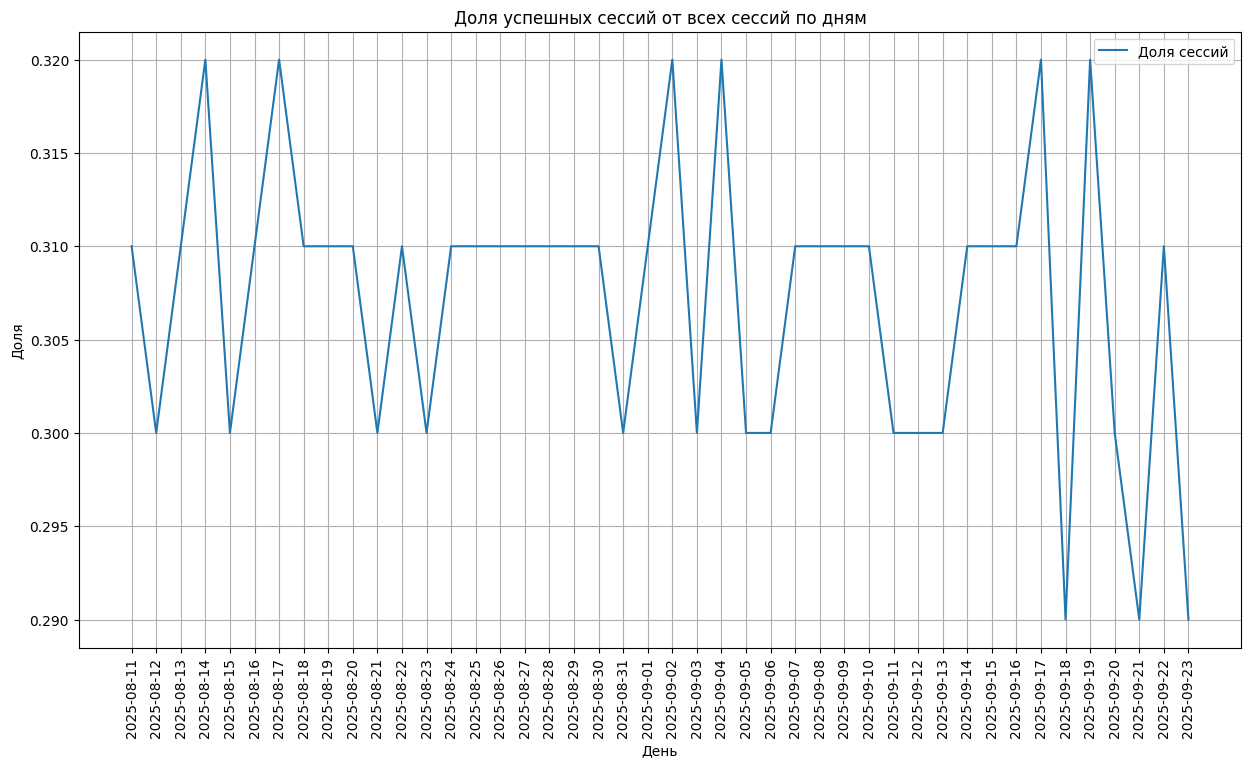

session_date
2025-08-11    0.31
2025-08-12    0.30
2025-08-13    0.31
2025-08-14    0.32
2025-08-15    0.30
2025-08-16    0.31
2025-08-17    0.32
2025-08-18    0.31
2025-08-19    0.31
2025-08-20    0.31
2025-08-21    0.30
2025-08-22    0.31
2025-08-23    0.30
2025-08-24    0.31
2025-08-25    0.31
2025-08-26    0.31
2025-08-27    0.31
2025-08-28    0.31
2025-08-29    0.31
2025-08-30    0.31
2025-08-31    0.30
2025-09-01    0.31
2025-09-02    0.32
2025-09-03    0.30
2025-09-04    0.32
2025-09-05    0.30
2025-09-06    0.30
2025-09-07    0.31
2025-09-08    0.31
2025-09-09    0.31
2025-09-10    0.31
2025-09-11    0.30
2025-09-12    0.30
2025-09-13    0.30
2025-09-14    0.31
2025-09-15    0.31
2025-09-16    0.31
2025-09-17    0.32
2025-09-18    0.29
2025-09-19    0.32
2025-09-20    0.30
2025-09-21    0.29
2025-09-22    0.31
2025-09-23    0.29
Name: session_id, dtype: float64

In [13]:
# Сохраняем переменную с общим количеством сессий по датам
all_sessions = sessions_history.groupby('session_date')['session_id'].count()

# Фильтруем данные и сохранеям в переменную только успешные сессии
lucky_sessions = sessions_history[sessions_history['good_session']==1]

# Сохраняем в переменную количество успешных сессий по датам
lucky_sessions = lucky_sessions.groupby('session_date')['session_id'].count()

# Считаем долю успешных сессий от их общего числа по датам
part_sessions = round(lucky_sessions/all_sessions, 2)

# Строим линейнфй график, отображающий долю успешных сесиий от их общего числа по датам
plt.figure(figsize=(15, 8))
plt.plot(
    part_sessions.index,
    part_sessions.values,
    label='Доля сессий')
plt.xlabel("День")
plt.xticks(rotation=90)
plt.legend()
plt.ylabel('Доля')
plt.title('Доля успешных сессий от всех сессий по дням')
plt.grid(True)
plt.show()

display(part_sessions)

Промежуточный вывод:
- График доли успешных сессий имеет резкие скачки и спады, к концу периода спады становятся более резкими.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

О какой метрике идёт речь? Как она будет учтена в формулировке гипотез?

- Целевая метрика: Доля успешнх сессий. Успешная сессия - сессия, в рамках которой пользователь просмотрел 4 и более страниц, так как это свидетельствует об удовлетворённости контентом и алгоритмами рекомендаций.

- Нулевая гипотеза (Н0): Целевая метрика (доля успешных сессий) в контрольной группе (группа А) и тестовой группе(группа В) равны, то есть новый алгоритм не сработал и вовлеченность пользовтелей не увеличилась в тестовой группе.

- Альтернативная гипотеза (Н1): Целевая метрика (доля успешынх сессий) в тествой группе имеет большее значение, чем в контрольной, то есть новый алгоритм сработал и вовлеченность пользователей увеличилась.

#### 2.2. Расчёт размера выборки
В рамках курса вы уже рассчитывали размеры выборки и  использовали для этого онлайн-калькулятор. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используйте метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [14]:

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2 # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03* p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [15]:

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round(sessions_history.groupby('session_date')['user_id'].nunique().mean(), 2)

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.36 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей  

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

<a id='1'></a>

In [16]:
# Сохраним датафрейм с данными о сессиях пользователей за первый день проведения теста
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

# Рассчитаем кол-во уникальных пользователей для групп А и В
a = sessions_test_part[sessions_test_part['test_group']=='A']['user_id'].nunique()
b = sessions_test_part[sessions_test_part['test_group']=='B']['user_id'].nunique()

# Рассчитаем процентную разницу между группами
perc = round(100*((abs(a-b))/a), 2)


print(f"Количество уникальных пользователей в группе А составило: {a}, в группе В: {b}. Процентная разница между двумя группами = {perc}%")

Количество уникальных пользователей в группе А составило: 1477, в группе В: 1466. Процентная разница между двумя группами = 0.74%


Промежуточный вывод:
- Можно заметить, что процентная разница составила менее 1%. Можно сделать вывод, что такая разница не окажет существенного влияния на проведение теста.
- В таком случае сложно выбрать какую-либо визуализацию, так точно отражающую маленькую разницу между группами. поэтому сделаем сводную таблицу с относительными значениями кол-ва уникальных пользователей по группам.

In [17]:
# Считаем кол-во уникальных пользователей по группам и сохранем эти значения в одну переменную
ab = sessions_test_part.groupby('test_group')['user_id'].nunique()

# Считаем общее кол-во уникальных пользователей
all_ab = sessions_test_part['user_id'].nunique()

# Считаем относительные значения кол-во уникальных пользователей по группам и сохранем эти значения в одну переменную
ab_perc = (ab/all_ab).reset_index()

# На основании ab_perc состалвяем сводную таблицу
piv5 = pd.pivot_table(ab_perc, values = 'user_id' , index='test_group')

display(piv5)

,user_id
test_group,
A,0.501869
B,0.498131


#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

<a id='2'></a>

In [18]:
# Посчитаем, в скольких уникальных тестовых группах участвовал каждый пользователь
user_group_counts = sessions_test_part.groupby('user_id')['test_group'].nunique().reset_index()

# Оставляем только пользователей, которые были более чем в одной группе
users_in_both = user_group_counts[user_group_counts['test_group'] > 1]

print(f'Количество пользователей, попавших одновременно в группы A и B: {len(users_in_both)}')

Количество пользователей, попавших одновременно в группы A и B: 0


#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.

<a id='3'></a>

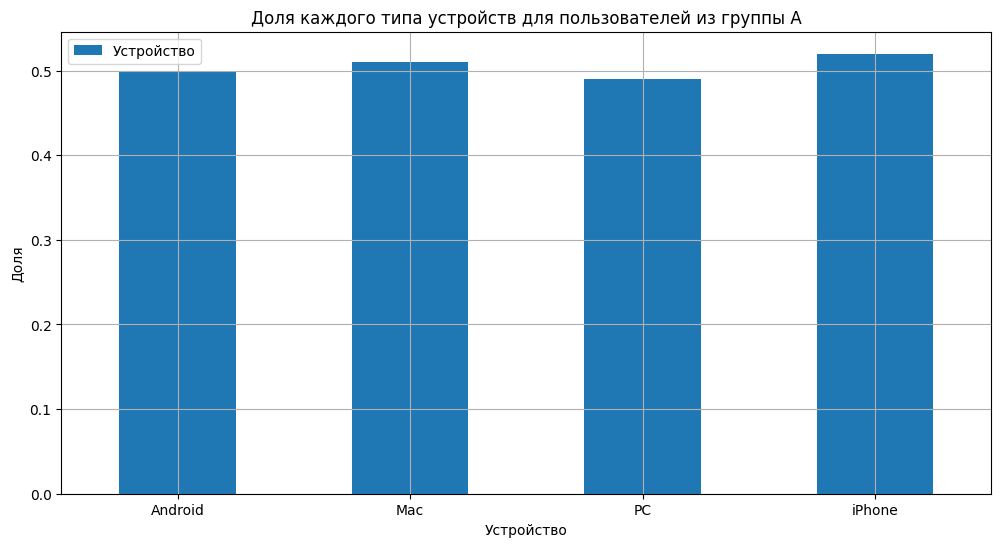

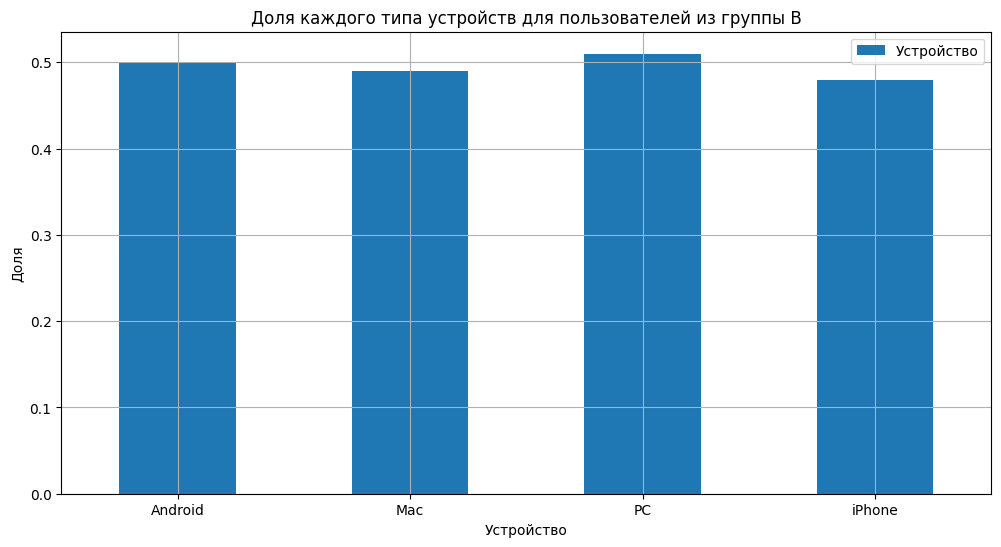

device
Android    0.50
Mac        0.51
PC         0.49
iPhone     0.52
Name: user_id, dtype: float64

device
Android    0.50
Mac        0.49
PC         0.51
iPhone     0.48
Name: user_id, dtype: float64

In [19]:
# Считаем кол-во пользователей по устройствам для двух групп
dev_a = sessions_test_part[sessions_test_part['test_group']== 'A'].groupby('device')['user_id'].nunique()
dev_b = sessions_test_part[sessions_test_part['test_group']== 'B'].groupby('device')['user_id'].nunique()

# Считаем общее кол-во пользователей по устройствам
dev_all = sessions_test_part.groupby('device')['user_id'].nunique()

# Считаем доли каждого типа устройства для пользователей каждой группы
dev_part_a = round(dev_a/dev_all, 2)
dev_part_b = round(dev_b/dev_all, 2)

# Строим столбчатую диаграмму для группы А
dev_part_a.plot(kind='bar', x='device', y='user_id', figsize=(12, 6), label = 'Устройство')
plt.xlabel('Устройство')
plt.xticks(rotation=0)
plt.legend()
plt.ylabel('Доля')
plt.title('Доля каждого типа устройств для пользователей из группы А')
plt.grid(True)
plt.show()

# Строим столбчатую диаграмму для группы В
dev_part_b.plot(kind='bar', x='device', y='user_id', figsize=(12, 6), label = 'Устройство')
plt.xlabel('Устройство')
plt.xticks(rotation=0)
plt.legend()
plt.ylabel('Доля')
plt.title('Доля каждого типа устройств для пользователей из группы B')
plt.grid(True)
plt.show()

# Выводим данные для уточнения результатов
display(dev_part_a)
display(dev_part_b)

Промежуточный вывод:
- В группе А наибольшая доля у устройства iPhone, меньшая у РС.
- В группе В наибольшая доля у устройства PC, наименьшая у iPhone.
- В целом доли устройств между группами имеют небольшие различия, которые не окажут существенного влияния на проведение теста.

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


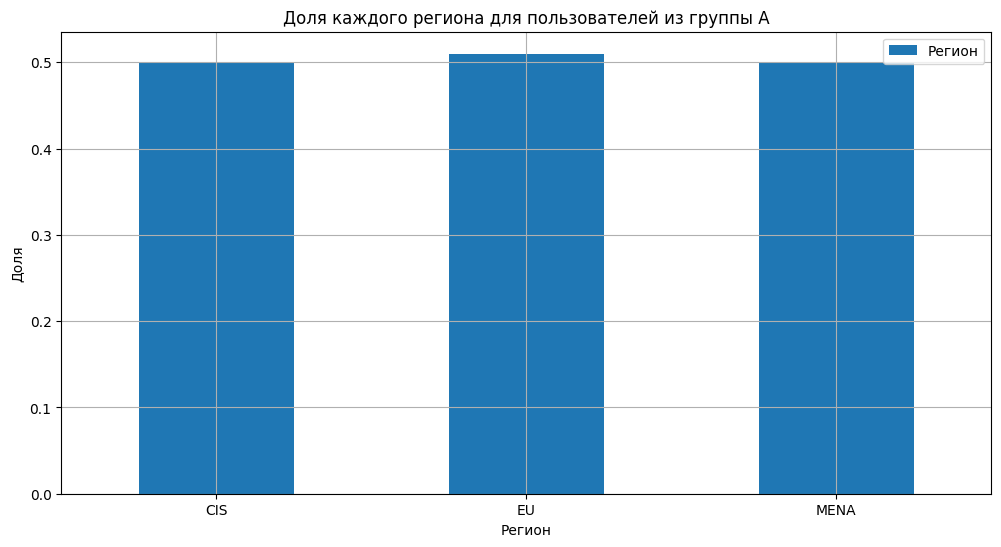

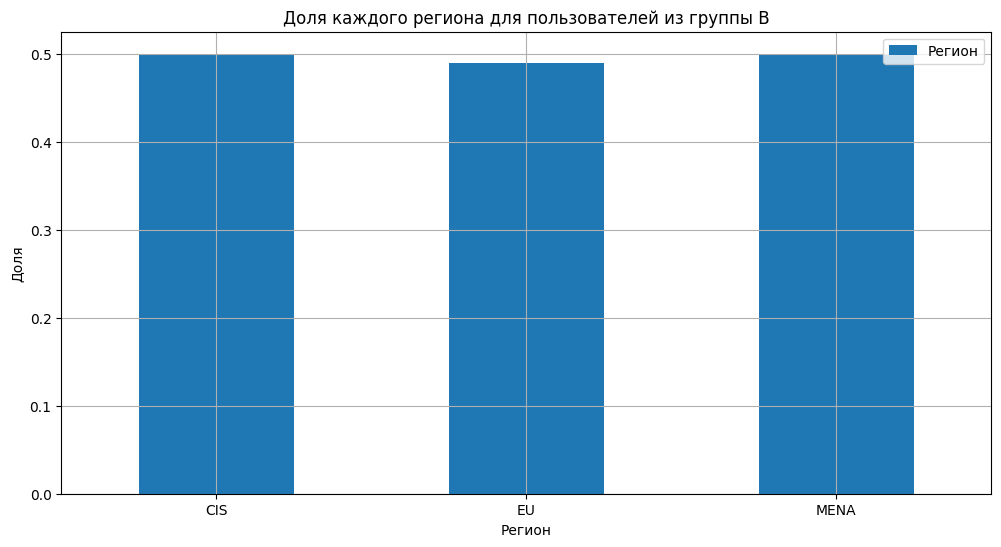

region
CIS     0.50
EU      0.51
MENA    0.50
Name: user_id, dtype: float64

region
CIS     0.50
EU      0.49
MENA    0.50
Name: user_id, dtype: float64

In [20]:
# Считаем кол-во пользователей по регионам для двух групп
reg_a = sessions_test_part[sessions_test_part['test_group']== 'A'].groupby('region')['user_id'].nunique()
reg_b = sessions_test_part[sessions_test_part['test_group']== 'B'].groupby('region')['user_id'].nunique()

# Считаем общее кол-во пользователей по регионам
reg_all = sessions_test_part.groupby('region')['user_id'].nunique()

# Считаем доли каждого региона для пользователей каждой группы
reg_part_a = round(reg_a/reg_all, 2)
reg_part_b = round(reg_b/reg_all, 2)

# Строим столбчатую диаграмму для группы А
reg_part_a.plot(kind='bar', x='region', y='user_id', figsize=(12, 6), label = 'Регион')
plt.xlabel('Регион')
plt.xticks(rotation=0)
plt.legend()
plt.ylabel('Доля')
plt.title('Доля каждого региона для пользователей из группы А')
plt.grid(True)
plt.show()

# Строим столбчатую диаграмму для группы В
reg_part_b.plot(kind='bar', x='region', y='user_id', figsize=(12, 6), label = 'Регион')
plt.xlabel('Регион')
plt.xticks(rotation=0)
plt.legend()
plt.ylabel('Доля')
plt.title('Доля каждого региона для пользователей из группы B')
plt.grid(True)
plt.show()

# Выводим данные для уточнения результатов
display(reg_part_a)
display(reg_part_b)

Промежуточный вывод:
- В группе А наибольшая доля у региона EU, меньшая у CIS и MENA.
- В группе В наибольшая доля у региона MENA и CIS, наименьшая у EU.
- В целом доли регионов между группами имеют небольшие различия, которые не окажут существенного влияния на проведение теста.

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение: корректно ли проходит A/B-тест, или наблюдаются какие-либо нарушения.

Итоговый вывод:
- Различия в количестве пользователей в двух группах [было обнаружено](#1), но совсем не значительное, оно составило менее 1 %. Такое различие не окажет влияния на проведение теста, оно находится в пределах допустимых значений.
- Выборки являются независимыми, пересечения пользователей по группам [выявлено не было](#2).
- Равномерность сохраняется [по обеим категориям](#3) (устройства и регионы). Можно наблюдать небольшие различия в долях, но все они небольшие (0.1-0.3) и влияния на проведения теста не окажут, так как находятся в пределах нормы.

Заключение: А/В тест проходит корректно.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [21]:
# Сохраняем датафрейм sessions_test
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Создаем столбец good_session, который определяет успешность сессии
good_session = []

for i in sessions_test['page_counter']:
    if i >=4:
        good_session.append(1)
    else:
        good_session.append(0)

sessions_test['good_session'] = good_session

display(sessions_test.head(5))


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [22]:
# H0: выборочные средние значения основной метрики равны (или различия статистически не значимы)

# H1: выборочное среднее значение основной метрики в группе А больше, чем в группе В


# Считаем кол-во уникальных сессий для каждого дня и обеих групп
sessions_unique = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

display(sessions_unique)


# Считаем метрики для обеих групп
metric_a = sessions_unique[sessions_unique['test_group'] == 'A']['session_id']
metric_b = sessions_unique[sessions_unique['test_group'] == 'B']['session_id']

# Устанавливаем уровень значимости
alpha = 0.05

# проводим статистический тест
stat_ttest, p_value_ttest = ttest_ind(
	metric_a,
	metric_b,
	alternative= 'greater'
)

# Выводим значение p-value
print(f'pvalue={p_value_ttest}')

# Проверяем нулевую гипотезу
if p_value_ttest>alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')

text_interpretation = 'не различается или различия не значимы'

print(f'Количество уникальных дневных сессий в двух выборках {text_interpretation}')

,session_date,test_group,session_id
0,2025-10-14,A,1502
1,2025-10-14,B,1628
2,2025-10-15,A,2235
3,2025-10-15,B,2283
4,2025-10-16,A,3280
5,2025-10-16,B,3241
6,2025-10-17,A,4089
7,2025-10-17,B,4054
8,2025-10-18,A,5013
9,2025-10-18,B,5059


pvalue=0.530890347570442
Нулевая гипотеза находит подтверждение!
Количество уникальных дневных сессий в двух выборках не различается или различия не значимы


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [23]:
sessions_test_part_aa = sessions_test[sessions_test['test_group']== 'A']['good_session'].count()
sessions_test_part_bb = sessions_test[sessions_test['test_group']== 'B']['good_session'].count()


sessions_test_part_allall =sessions_test['good_session'].count()

stpa = sessions_test_part_aa/sessions_test_part_allall
stpb = sessions_test_part_bb/sessions_test_part_allall

print(f'Доли успешных сессий в группе А: {stpa} и в группе В: {stpb}. В группе В доля больше, чем в группе А.')

stp = stpb-stpa

print(f'Разница между долями успешных сессий в группе А и В: {stp}.')

Доли успешных сессий в группе А: 0.49548522573871306 и в группе В: 0.5045147742612869. В группе В доля больше, чем в группе А.
Разница между долями успешных сессий в группе А и В: 0.009029548522573816.


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [24]:

n_a = sessions_test[ # посчитайте размер группы A
    sessions_test.test_group== 'A'
].shape[0]

n_b = sessions_test[ # посчитайте размер группы B
    sessions_test.test_group=='B'
].shape[0]

m_a = sessions_test[ # посчитайте кол-во успехов в группе A
    (sessions_test.test_group=='A')&(sessions_test.good_session==1)
].shape[0]

m_b = sessions_test[ # посчитайте количество успехов в группе B
     (sessions_test.test_group=='B')&(sessions_test.good_session==1)
].shape[0]

p_a, p_b = m_a/n_a, m_b/n_b # посчитайте доли успехов для каждой группы: A и B

if  (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10): # проверьте предпосылку о достаточном количестве данных
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

alpha =  0.05 ## установите уровень значимости


stat_ztest, p_value_ztest = proportions_ztest( # проведите Z-тест пропорций
	 [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

print(f'pvalue={p_value_ztest}') # выведите полученное p-value

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')
print('В группе В количество успешных сессий больше, чем в группе А')

Предпосылка о достаточном количестве данных выполняется!
pvalue=0.00015747399880361237
Нулевая гипотеза не находит подтверждения!
В группе В количество успешных сессий больше, чем в группе А


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Размер выборки для каждой группы: 41040, то есть всего было задейстовано 82080 пользователей.
- Даты проведения эксперимента: 2025-10-14 по 2025-11-02.
- Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.36 пользователей в день составит 9 дней.

- Целевая метрика: Доля успешнх сессий. Успешная сессия - сессия, в рамках которой пользователь просмотрел 4 и более страниц, так как это свидетельствует об удовлетворённости контентом и алгоритмами рекомендаций.

- Нулевая гипотеза (Н0): Целевая метрика (доля успешных сессий) в контрольной группе (группа А) и тестовой группе(группа В) равны, то есть новый алгоритм не сработал и вовлеченность пользовтелей не увеличилась в тестовой группе.

- Альтернативная гипотеза (Н1): Целевая метрика (доля успешынх сессий) в тествой группе имеет большее значение, чем в контрольной, то есть новый алгоритм сработал и вовлеченность пользователей увеличилась.


Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Да, мы выяснили в последнем пункте, что количетсво успешных сессий в тестовой группе больше, чем в контрольной, что свидетельствует об успешном внедрении нового алгоритма.

Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- pvalue=0.0001574739988036123

Стоит ли внедрять нововведение в приложение.

- Да, стоит, так как эксперимент показал, что нововведение положительно алияет на развитие продуктаЮ вовлеченность пользователей растет.